In [1]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The dataset we have chosen is the statistics of the top 500 players, which gives the statistics of the top 500 tennis players. By using this dataset, we can predict if a tennis player is currently ranked in the top 150 by their age and their best ranking.

In [2]:
#using the read_csv function to load data from web
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


After loading the data, we first selected any columns that might be relevant to our study topic, these were age, prize money, current ranking, best ranking, match, backhand, and height. After we checked the NA values in each column, the NA values in the height column were very high, so we chose not to include the height column in our model.

In [3]:
set.seed(999)
#select the variables we want to use and check how many NA rows there are in each column.
tennis_data <- tennis |>
  select(Age, 'Prize Money', 'Current Rank', 'Best Rank', Plays, Backhand, Height) |>
map_df(~sum(is.na(.)))
tennis_data

Age,Prize Money,Current Rank,Best Rank,Plays,Backhand,Height
<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,81,5,1,47,92,385


After that, we check the details of each variable. The table shows that the Plays and Backhand columns are categorical variables and may not be good predictors, so we chose not to use these two variables in the model.

In [4]:
set.seed(999)
#check the values of each column
tennis_data <- tennis |>
select(Age, 'Prize Money', 'Current Rank', 'Best Rank', Plays, Backhand) 
names(tennis_data) <- c("Age", "Prize", "Current_rank", 'Best_rank', "Plays", "Backhand")
tennis_data <- tennis_data |>
  select(Age, Prize, Current_rank, Best_rank, Plays, Backhand)
head(tennis_data)

Age,Prize,Current_rank,Best_rank,Plays,Backhand
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
26 (25-04-1993),NA,378 (97),363 (04-11-2019),Right-handed,NA
18 (22-12-2001),"$59,040",326 (119),316 (14-10-2019),Left-handed,Two-handed
32 (03-11-1987),"US$3,261,567",178 (280),44 (14-01-2013),Right-handed,Two-handed
21 (29-05-1998),"$374,093",236 (199),130 (10-04-2017),Right-handed,Two-handed
27 (21-10-1992),"US$6,091,971",183 (273),17 (11-01-2016),Right-handed,Two-handed
22 (11-02-1997),"$1,517,157",31 (1398),31 (20-01-2020),Right-handed,Two-handed


By following the steps below, we remove all special symbols such as date of birth, dollar sign, etc. from each column and filter out any rows that contain NA values for the selected column. In addition, by using the iselse function, we divide the current ranking columns into two categories, i.e. top 150 and non-top 150, which will be the outcome of our model.

In [5]:
set.seed(999)
tennis_data <- tennis_data |>
select(Age, Prize, Current_rank, Best_rank) |>
mutate(across(Age: Best_rank, function(col) {str_extract(col, "^[^ ]+")}))|>
mutate(Prize = as.numeric(gsub("[^0-9.]+", "", Prize)))|>
                mutate(Age = as.numeric(Age))|>
                mutate(Current_rank = as.numeric(Current_rank)) |>
                mutate(Best_rank = as.numeric(Best_rank)) |>
  filter(!is.na(Prize) & !is.na(Age) & !is.na(Current_rank) & !is.na(Best_rank)) |>
  mutate(rank_top_150 = ifelse(Current_rank <= 150, "top 150", "not top 150")) |> # convert chr to fct
    mutate(rank_top_150 = as.factor(rank_top_150)) |>
  select(Age, Prize, rank_top_150, Best_rank)#select only the columns we need

head(tennis_data)

Age,Prize,rank_top_150,Best_rank
<dbl>,<dbl>,<fct>,<dbl>
18,59040,not top 150,316
32,3261567,not top 150,44
21,374093,not top 150,130
27,6091971,not top 150,17
22,1517157,top 150,31
28,278709,not top 150,213


The ggplot function was used to generate scatter plots to see the correlation of each numerical variable. According to the scatter plot, the other two plots have a high degree of overlap, but the age and best rank plots do not have much overlap. Therefore, we will use only age and best ranking as predictor variables in our model.

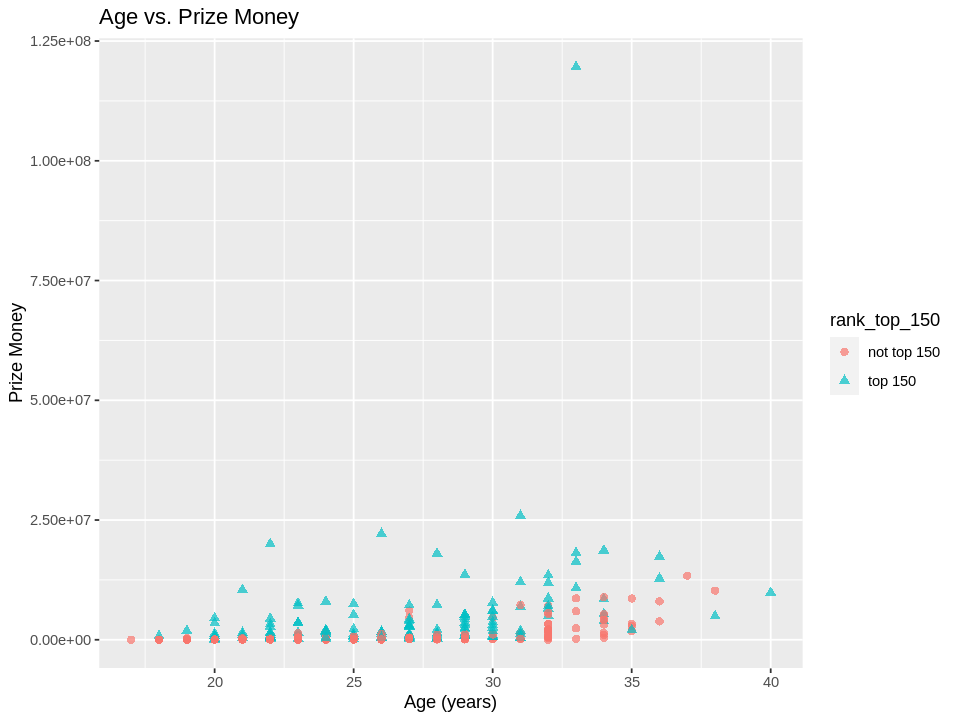

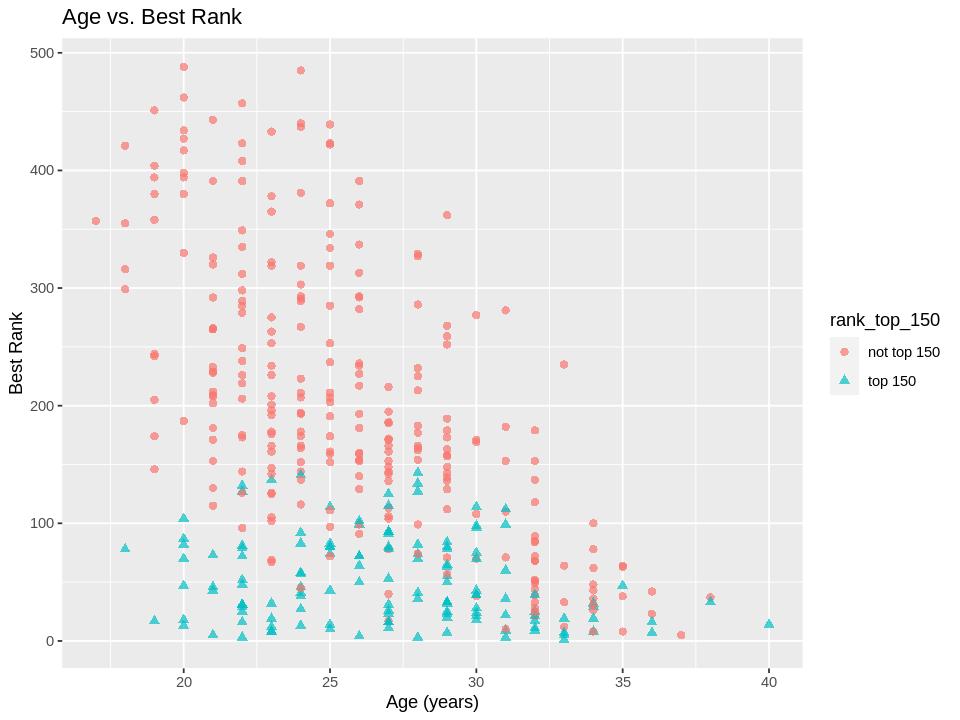

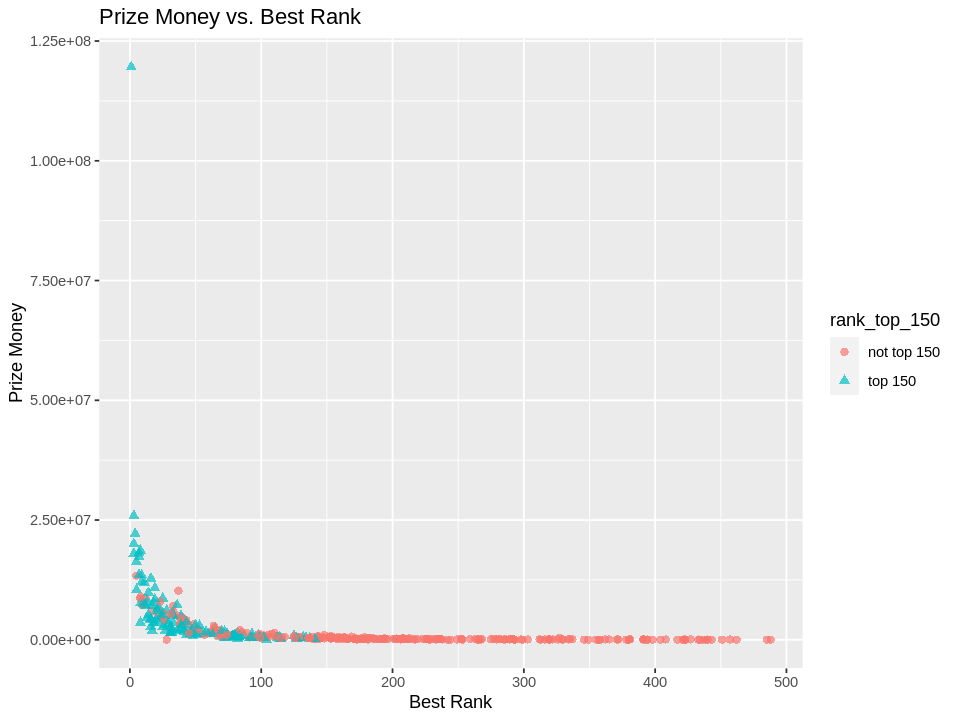

In [6]:
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(tennis_data, aes(x = Age, y = Prize, color = rank_top_150,
                                            shape = rank_top_150)) +
  geom_point(alpha = 0.7, size = 2) + 
  labs(title = "Age vs. Prize Money", 
    x = "Age (years)", y = "Prize Money") 

ggplot(tennis_data, aes(x = Age, y = Best_rank, color = rank_top_150,
                                                shape = rank_top_150)) +
  geom_point(alpha = 0.7, size = 2) + 
  labs(title = "Age vs. Best Rank", 
    x = "Age (years)", y = "Best Rank") 


ggplot(tennis_data, aes(x = Best_rank, y = Prize, color = rank_top_150,
                                                shape = rank_top_150)) +
  geom_point(alpha = 0.7, size = 2) + 
  labs(title = "Prize Money vs. Best Rank", 
    x = "Best Rank", y = "Prize Money") 

In [7]:
#select the final variables that we need for our model
tennis_data <- tennis_data |>
select(Age, rank_top_150, Best_rank)
head(tennis_data)

Age,rank_top_150,Best_rank
<dbl>,<fct>,<dbl>
18,not top 150,316
32,not top 150,44
21,not top 150,130
27,not top 150,17
22,top 150,31
28,not top 150,213


Then, we first use the initial_split function to separate the data to training and test sets. We specify that prop = 0.75 so that 75% of our original data set ends up in the training set. We can see from glimpse in the code that the training set contains 294 rows, while the test set contains 99 rows, which corresponds to the split of 75% / 25%.

In [8]:
set.seed(999)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = rank_top_150)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)
glimpse(tennis_train)
glimpse(tennis_test)

Rows: 294
Columns: 3
$ Age          <dbl> 18, 32, 21, 27, 28, 21, 30, 30, 26, 24, 21, 28, 20, 22, 2…
$ rank_top_150 <fct> not top 150, not top 150, not top 150, not top 150, not t…
$ Best_rank    <dbl> 316, 44, 130, 17, 213, 229, 171, 277, 293, 291, 228, 166,…
Rows: 99
Columns: 3
$ Age          <dbl> 22, 25, 20, 28, 23, 30, 22, 30, 22, 28, 26, 34, 27, 22, 3…
$ rank_top_150 <fct> top 150, not top 150, top 150, top 150, not top 150, top …
$ Best_rank    <dbl> 31, 253, 104, 143, 319, 98, 312, 75, 238, 164, 371, 48, 2…


The table below shows the percentage of top 150 and non-top 150 tennis players, and it can be seen that after we filter out the rows containing NA values, the number of top 500 players is left at 294, with 99 top 150 players and 195 non-top 150 players. In terms of percentages, about 1/3 of tennis players are top 150 and 2/3 of tennis players are not top 150.

In [9]:
set.seed(999)
tennis_proportions <- tennis_train |>
                      group_by(rank_top_150) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(tennis_train))

tennis_proportions

rank_top_150,n,percent
<fct>,<int>,<dbl>
not top 150,195,66.32653
top 150,99,33.67347


The mean and standard deviation of the age and prize money of top_150 and not_top_150 were calculated using the summarize function. According to the results, the average age of top 150 tennis players is 1.2 years older than that of non-top 150 tennis players, and the average best ranking of top 150 tennis players is about 3.85 times that of non-top 150 tennis players. In addition, the age standard deviation of the top 150 tennis players was 0.3 less than that of the non-top 150 tennis players, and the best ranking standard deviation of the top 150 tennis players was approximately 3.15 times higher than that of the non-top 150 tennis players. This shows that there is little age difference between the top 150 players and the players after them, which means that age does not greatly affect the current ranking.

In [10]:
set.seed(999)
tennis_summary_avg <- tennis_train %>%
  group_by(rank_top_150) %>%
  summarize(
    avg_age = mean(Age),
    avg_best_rank = mean(Best_rank)
  )

tennis_summary_avg

tennis_summary_sd <- tennis_train %>%
  group_by(rank_top_150) %>%
  summarize(
    sd_age = sd(Age),
    sd_best_rank = sd(Best_rank)
  )

tennis_summary_sd

rank_top_150,avg_age,avg_best_rank
<fct>,<dbl>,<dbl>
not top 150,25.75897,202.25128
top 150,26.96970,52.45455


rank_top_150,sd_age,sd_best_rank
<fct>,<dbl>,<dbl>
not top 150,4.475403,117.6414
top 150,4.195368,37.3951


The scatter plots below shows the correlation between the age of the players and their best rank on the x and y axes. According to the plot, it appears that the older the player are, their best ranking gets higher, while the top 150 players have a higher percentage of best rankings than non-top 150 players. 

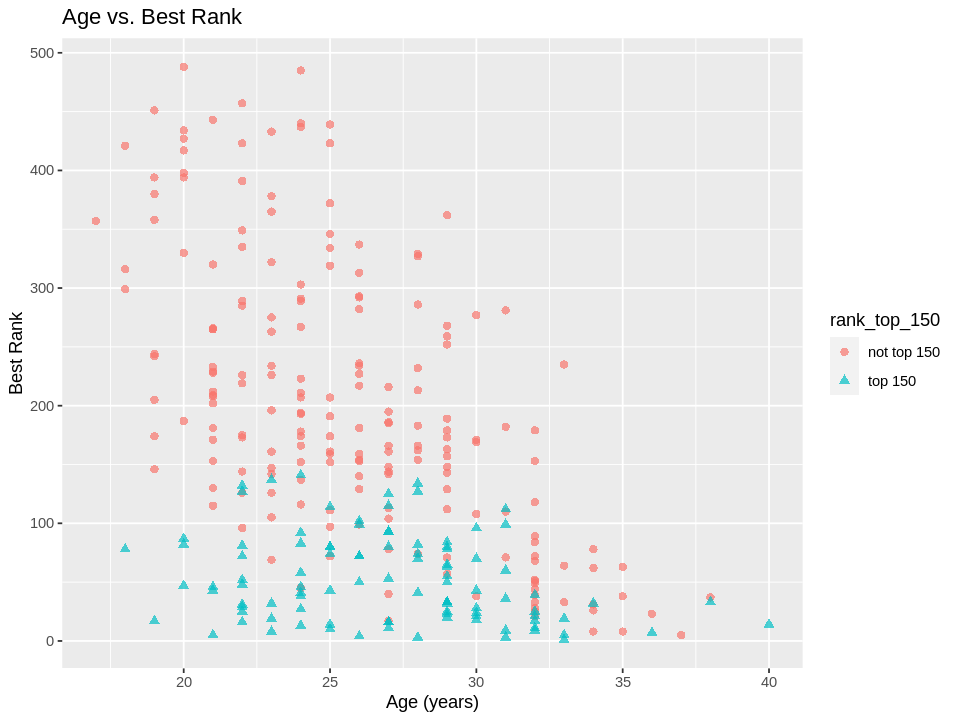

In [11]:
options(repr.plot.height = 6, repr.plot.width = 8)
ggplot(tennis_train, aes(x = Age, y = Best_rank, color = rank_top_150,
                                                shape = rank_top_150)) +
  geom_point(alpha = 0.7, size = 2) + 
  labs(title = "Age vs. Best Rank", 
    x = "Age (years)", y = "Best Rank") 

The k-nearest neighbors（knn) algorithm is used to find the optimal set of hyperparameters. The performance of the model is evaluated using 10-fold cross-validation. The accuracy is used to assess the performance of our model. 

In [12]:
set.seed(999) 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tennis_recipe <- recipe(rank_top_150 ~., data = tennis_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = rank_top_150)

knn_results <- workflow() |>
                 add_recipe(tennis_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = tennis_vfold, grid = 10) |>
                 collect_metrics()

accuracy <- knn_results |>
                 filter(.metric == 'accuracy')
accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7996141,10,0.01746573,Preprocessor1_Model1
4,accuracy,binary,0.8337603,10,0.01401414,Preprocessor1_Model2
5,accuracy,binary,0.8539984,10,0.01088923,Preprocessor1_Model3
6,accuracy,binary,0.8539984,10,0.01088923,Preprocessor1_Model4
7,accuracy,binary,0.8608949,10,0.01136326,Preprocessor1_Model5
9,accuracy,binary,0.8575616,10,0.01685549,Preprocessor1_Model6
10,accuracy,binary,0.8608949,10,0.01425475,Preprocessor1_Model7
12,accuracy,binary,0.8506568,10,0.01644906,Preprocessor1_Model8
14,accuracy,binary,0.8676765,10,0.01243970,Preprocessor1_Model9


We can determine the best value of k to enhance the accuracy of the model by examining the connection between k and accuracy. This data can be employed to increase the model's efficiency and generate more precise forecasts.

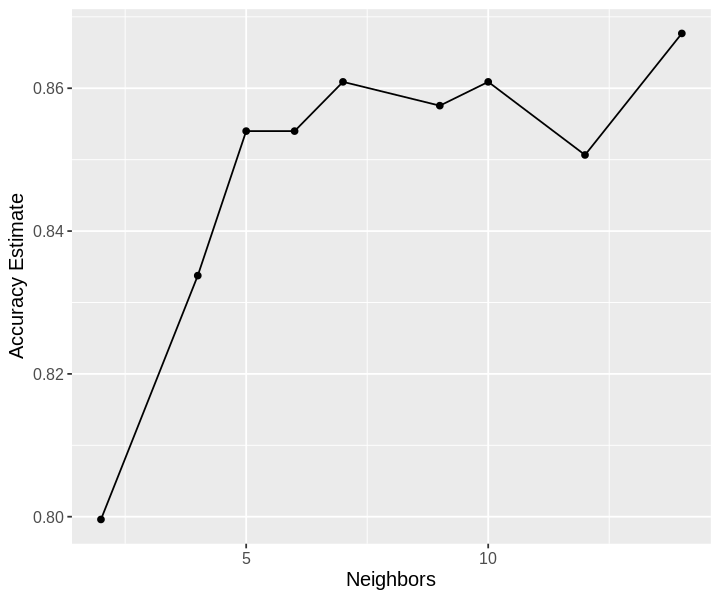

In [13]:
set.seed(999) 
options(repr.plot.height = 5, repr.plot.width = 6)
accuracy_vs_k <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 12))

accuracy_vs_k

According to the above figure, the number of neighbors should be 13-14 in order to get the highest accuracy, so we set K = 14. By following the steps below, we can help test the accuracy of our model. 

In [14]:
set.seed(999)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
             add_recipe(tennis_recipe) |>
             add_model(knn_spec) |>
            fit(data = tennis_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(14,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1394558
Best kernel: rectangular
Best k: 14

Finally, we can test the accuracy of our model with test set and get the accuracy data chart. From the results, it shows that our model has 86.9% accuracy, and out of 99 test observations, 86 are detected correctly and 13 are incorrect.

In [15]:
set.seed(999) 
tennis_predictions <- predict(knn_fit, tennis_test) |>
bind_cols(tennis_test)
head(tennis_predictions)

tennis_metrics <- tennis_predictions |>
         metrics(truth = rank_top_150, estimate = .pred_class) |>
  filter(.metric == "accuracy")
tennis_metrics

tennis_mat <- tennis_predictions |>
         conf_mat(truth = rank_top_150, estimate = .pred_class)
tennis_mat


.pred_class,Age,rank_top_150,Best_rank
<fct>,<dbl>,<fct>,<dbl>
top 150,22,top 150,31
not top 150,25,not top 150,253
top 150,20,top 150,104
not top 150,28,top 150,143
not top 150,23,not top 150,319
top 150,30,top 150,98


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8686869


             Truth
Prediction    not top 150 top 150
  not top 150          59       6
  top 150               7      27